# A 股预测
<br>
<hr>

# 1.实验介绍


## 1.1 实验背景
时间序列分析在金融、证券领域的应用非常广泛，尤其是对股票价格的预测。我们对数据进行预处理，接着使用数据分析方法，建立基础特征，进一步构建线性回归模型，且基于新数据验证模型效果。



## 1.2 实验要求
输入某股票前 14 个交易日的收盘价，预测下一个交易日的收盘价。

实验指标为平均绝对百分比误差（ `MAPE` ）和平均绝对误差（ `MAE` ）。



## 1.3 实验环境 
可以使用基于 `Python` 的 `Pandas` 、 `Numpy` 、`Scikit-learn` 等库进行相关特征处理，使用 `Keras`、`TensorFlow`、`PyTorch` 等框架建立深度学习模型，使用过程中请注意 `Python` 包（库）的版本。



## 1.4 注意事项
- 使用平台的注意事项

该平台的 `Notebook` 在 `CPU` 上运行，故尽量不要尝试在 `Notebook` 上做希望让 `GPU` 做的工作。

- 训练模型的注意事项

如果想要线下训练模型，请保证线下的环境与该平台一致，否则可能无法在该平台运行，可以在该平台的 `terminal` 输入```pip list```查看对应包版本。

- 该作业的注意事项

该作业目的在于加深对空间和时序模型的理解和运用，理论上作品的预测相关指标不应低于基本模型。



## 1.5 参考资料
- 相关框架的文档

scikit-learn: https://scikit-learn.org/stable/

tensorflow: https://tensorflow.google.cn/tutorials?hl=zh_cn

PyTorch: https://pytorch.org/tutorials/

- 框架的学习教程

《动手学深度学习》(PyTorch版): https://tangshusen.me/Dive-into-DL-PyTorch/

《深度学习框架PyTorch：入门与实战》: https://github.com/chenyuntc/pytorch-book

# 2.实验内容

## 2.1 数据集

数据集由网上的相关平台获取，训练集给出了五十几支股票的情况。数据以 `npy` 格式给出，名称为`train_data.npy` 。


In [29]:
# 首先 import 一些主要的包
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os

# 画图使用
%matplotlib inline

In [30]:
# 简单读出一个股票

# 获取文件名
file_name = 'train_data.npy'

# 读取数组
data = np.load(file_name)

# 简单展示信息
data

array([15.35, 15.13, 15.01, ...,  2.93,  2.79,  2.84])

接下来可以对其进行绘制，这样可以具体感受到股价的变化。

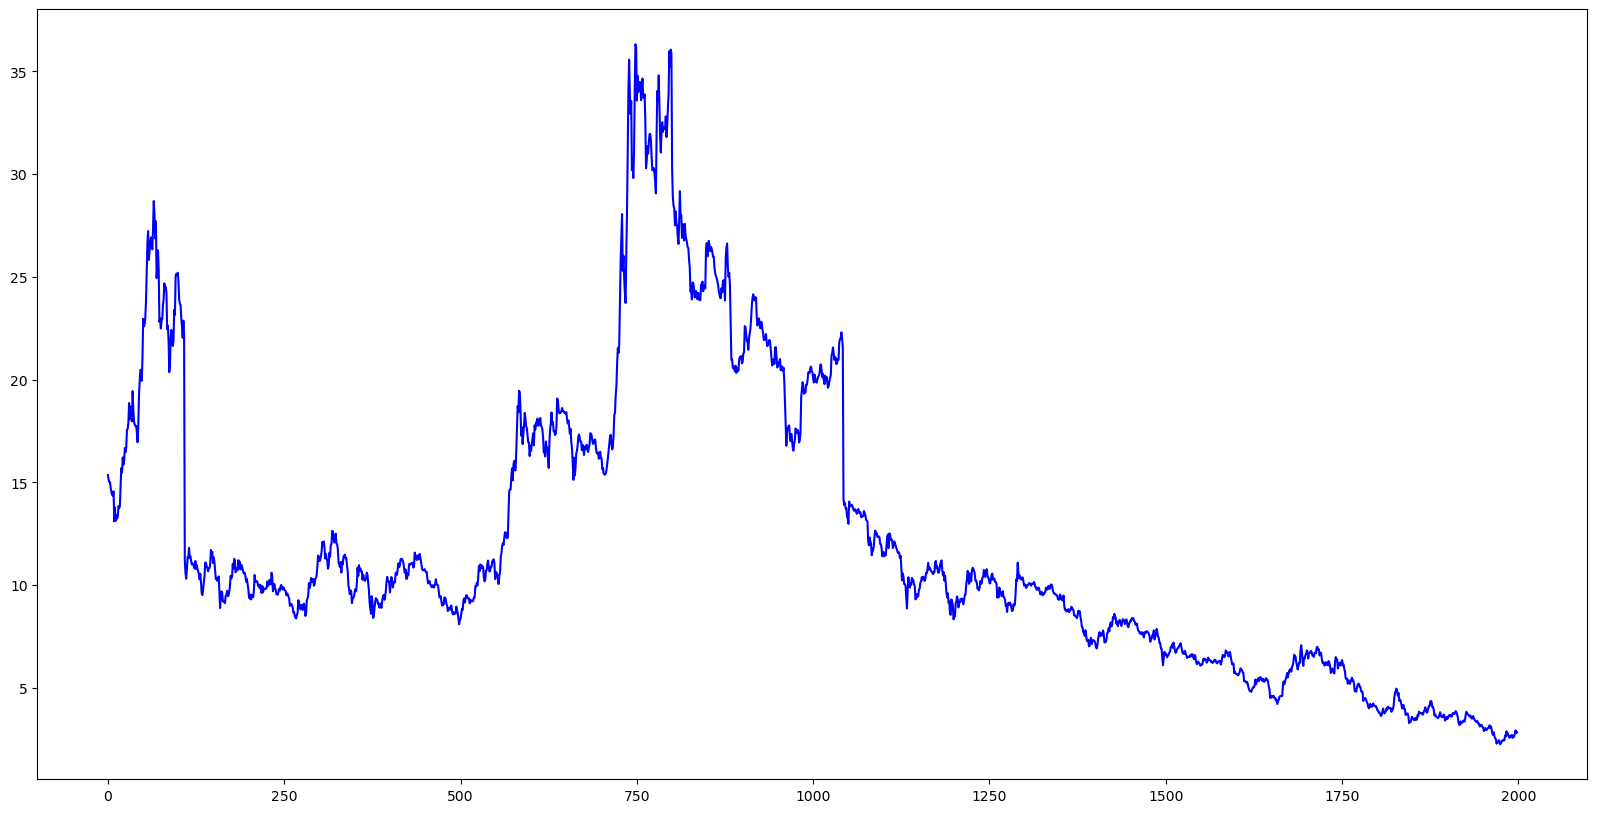

In [31]:
# 新建一个图像
plt.figure(figsize=(20,10))

# 绘画该股票不同的时间段的图像
plt.plot(data,c='blue')

# 展示图像
plt.show()

注意到波动还是比较大的，且数值较大处和较小处相比差距存在，为了深度模型更好的工作，我们使用 `MinMaxScaler` 进行归一化。当然，用户也可以自行选择其他的预处理方式。

这里我们选用 `sklearn` 的 `Scaler` ，如果有兴趣，也可以使用 `torchvision` 或者自己实现相关内容。

当然， `MinMaxScaler` 并不是唯一的选择，甚至可能并不是正确的选择，这里只是用作示范，请自行学习相关内容并使用。

但注意，如果 `scaler` 运算后的结果小于或等于 $0$ 可能带来严重后果，因为指标之一是 `MAPE` 。

In [32]:
from sklearn.preprocessing import MinMaxScaler

# 这个 [0, 300] 是手动的预设值，可以自己更改
scaler = MinMaxScaler().fit(np.array([0, 300]).reshape(-1, 1))

## 2.2 数据处理


首先需要生成题目所需的训练集合。

In [33]:
# 生成题目所需的训练集合
def generate_data(data):
    
    # 记录 data 的长度
    n = data.shape[0]
    
    # 目标是生成可直接用于训练和测试的 x 和 y
    x = []
    y = []
        
    # 建立 (14 -> 1) 的 x 和 y
    for i in range(15, n):
        x.append(data[i-15:i-1])
        y.append(data[i-1])
            
    # 转换为 numpy 数组
    x = np.array(x)
    y = np.array(y)
        
    return x,y

x,y = generate_data(data)
print('x.shape : ', x.shape)
print('y.shape : ', y.shape)

x.shape :  (1984, 14)
y.shape :  (1984,)


然后对数据集合进行分割，其中训练集用于训练，校验集用于检验模型训练情况，测试集合用于测试模型效果。

In [34]:
# 生成 train valid test 集合，以供训练所需
def generate_training_data(x, y):
    # 样本总数
    num_samples = x.shape[0]
    # 测试集大小
    num_test = round(num_samples * 0.2)
    # 训练集大小
    num_train = round(num_samples * 0.7)
    # 校验集大小
    num_val = num_samples - num_test - num_train
    
    # 训练集拥有从 0 起长度为 num_train 的样本
    x_train, y_train = x[:num_train], y[:num_train]
    # 校验集拥有从 num_train 起长度为 num_val 的样本
    x_val, y_val = (
        x[num_train: num_train + num_val],
        y[num_train: num_train + num_val],
    )
    # 测试集拥有尾部 num_test 个样本
    x_test, y_test = x[-num_test:], y[-num_test:]
    
    # 返回这些集合
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = generate_training_data(x, y)
print('x_train.shape : ', x_train.shape)
print('y_train.shape : ', y_train.shape)
print('x_val.shape : ', x_val.shape)
print('y_val.shape : ', y_val.shape)
print('x_test.shape : ', x_test.shape)
print('y_test.shape : ', y_test.shape)

x_train.shape :  (1389, 14)
y_train.shape :  (1389,)
x_val.shape :  (198, 14)
y_val.shape :  (198,)
x_test.shape :  (397, 14)
y_test.shape :  (397,)


## 2.3 建立一个简单的模型

- 选用一种框架，告诉其创建模型的常用方式以及常用的接口
- 建立一个简单模型并进行训练保存
- 分析模型训练过程以及模型概况
- 加载模型并对模型进行评估
- **加载模型并预测输入数据的结果**

### 2.3.1 处理数据

该实验示范使用 `Pytorch` 完成。也可以选用其他框架进行训练并预测结果。

In [35]:
# 加载 pytorch
import torch

处理数据，并将其转化为 `Pytorch` 的形式。

In [36]:
# 获取数据中的 x, y
x,y = generate_data(data)

# 将 x,y 转换乘 tensor ， Pytorch 模型默认的类型是 float32
x = torch.tensor(x)
y = torch.tensor(y)

print(x.shape,y.shape)

# 将 y 转化形状
y = y.view(y.shape[0],1)

print(x.shape,y.shape)

torch.Size([1984, 14]) torch.Size([1984])
torch.Size([1984, 14]) torch.Size([1984, 1])


In [37]:
# 对 x, y 进行 minmaxscale
x_scaled = scaler.transform(x.reshape(-1,1)).reshape(-1,14)
y_scaled = scaler.transform(y)

x_scaled = torch.tensor(x_scaled, dtype=torch.float32)
y_scaled = torch.tensor(y_scaled, dtype=torch.float32)

In [38]:
# 处理出训练集，校验集和测试集
x_train, y_train, x_val, y_val, x_test, y_test = generate_training_data(x_scaled, y_scaled)

为了方便使用 `DataLoader` ，我们需要自定义一个 `Dataset` ，自定义的 `Dataset` 只需要继承后实现下面三个函数。

In [39]:
# 建立一个自定 Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
 
    def __getitem__(self, item):
        return self.x[item], self.y[item]
 
    def __len__(self):
        return len(self.x)

In [40]:
# 建立训练数据集、校验数据集和测试数据集
train_data = MyDataset(x_train,y_train)
valid_data = MyDataset(x_val,y_val)
test_data = MyDataset(x_test,y_test)

In [75]:
# 规定批次的大小
batch_size = 512

# 创建对应的 DataLoader
train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 校验集和测试集的 shuffle 是没有必要的，因为每次都会全部跑一遍
valid_iter = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
for i, read_data in enumerate(test_iter):
    # i表示第几个batch， data表示该batch对应的数据，包含data和对应的labels
    print("第 {} 个Batch \n{}".format(i, read_data))
    break
# 表示输出数据
print(read_data[0].shape, read_data[0])
# 表示输出标签
print(read_data[1].shape, read_data[1])

第 0 个Batch 
[tensor([[0.0223, 0.0224, 0.0217,  ..., 0.0193, 0.0190, 0.0189],
        [0.0224, 0.0217, 0.0222,  ..., 0.0190, 0.0189, 0.0189],
        [0.0217, 0.0222, 0.0225,  ..., 0.0189, 0.0189, 0.0187],
        ...,
        [0.0089, 0.0087, 0.0096,  ..., 0.0085, 0.0087, 0.0088],
        [0.0087, 0.0096, 0.0091,  ..., 0.0087, 0.0088, 0.0093],
        [0.0096, 0.0091, 0.0092,  ..., 0.0088, 0.0093, 0.0098]]), tensor([[0.0189],
        [0.0187],
        [0.0187],
        [0.0190],
        [0.0194],
        [0.0198],
        [0.0196],
        [0.0196],
        [0.0192],
        [0.0191],
        [0.0177],
        [0.0177],
        [0.0177],
        [0.0175],
        [0.0176],
        [0.0174],
        [0.0168],
        [0.0164],
        [0.0161],
        [0.0162],
        [0.0160],
        [0.0162],
        [0.0166],
        [0.0168],
        [0.0167],
        [0.0171],
        [0.0180],
        [0.0172],
        [0.0178],
        [0.0177],
        [0.0182],
        [0.0177],
        [0.0

### 2.3.2 建立模型

下面展示如何建立模型， `Pytorch` 的建立模型较为简单，只需要完成 `forward` ，即前向传播函数即可进行训练。这里展示建立一个简单的线性模型。参数 `Pytorch` 会自动初始化，具体请查看官方文档。

In [42]:
# 输入的数量是前 14 个交易日的收盘价
num_inputs = 14
# 输出是下一个交易日的收盘价
num_outputs = 1

# 建立一个简单的线性模型
class LinearNet(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        # 一个线性层
        self.linear = torch.nn.Linear(num_inputs, num_outputs)
        
    # 前向传播函数
    def forward(self, x): # x shape: (batch, 14)
        y = self.linear(x)
        return y

下面建立一个复杂但不太有效的 `LSTM` 模型，仅供理解 `Pytorch` 的运行方式而使用。

In [43]:
# 隐藏层的个数
num_hiddens = 128 
# 建立一个稍微复杂的 LSTM 模型
class LSTMNet(torch.nn.Module):
    def __init__(self, num_hiddens, num_outputs):
        super(LSTMNet, self).__init__()
        self.hidden_size = num_hiddens
        # RNN 层，这里的 batch_first 指定传入的是 (批大小，序列长度，序列每个位置的大小)
        # 如果不指定其为 True，传入顺序应当是 (序列长度，批大小，序列每个位置的大小)
        self.rnn = torch.nn.LSTM(input_size=num_inputs//24, hidden_size=num_hiddens,batch_first=True)
        # 线性层
        self.dense = torch.nn.Linear(self.hidden_size*24, 256)
        self.dense2 = torch.nn.Linear(256,num_outputs)
        # dropout 层，这里的参数指 dropout 的概率
        self.dropout = torch.nn.Dropout(0.3)
        self.dropout2 = torch.nn.Dropout(0.5)
        # ReLU 层
        self.relu = torch.nn.ReLU()
    
    # 前向传播函数，这是一个拼接的过程，使用大量变量是为了避免混淆，不做过多讲解
    def forward(self, x): # x shape: (batch_size, 24, 307)
        # LSTM 层会传出其参数，这里用 _ 将其舍弃
        h, _ = self.rnn(x)
        # LSTM 层会传出 (batch_size, 24, num_hiddens) 个参数，故需要 reshape 后丢入全连接层
        h_r = h.reshape(-1,self.hidden_size*24)
        h_d = self.dropout(h_r)
        y = self.dense(h_d)
        drop_y = self.dropout2(y)
        a = self.relu(drop_y)
        y2 = self.dense2(a)
        return y2

可以看到，`PyTorch`建立一个模型较为清楚简单，具体使用可以参考文档。

`PyTorch` 在使用 `GPU` 和 `CPU` 上的写法有所不同。在需要将保存在内存中的数据在 `GPU` 上运行时，需要主动将数据和模型拷贝到显存。

为了简化差异，我们使用一个布尔值：`use_gpu` 来判断是否可用 `GPU` ，从而淡化差异。这样就不需要写两份代码。

In [44]:
# 判断 gpu 是否可用
use_gpu = torch.cuda.is_available()

# 另一种写法是固定 device，每次调用数据都 to(device)即可
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2.3.3 评估函数建立

这里给出了评估使用的函数，可以自测以获得信息。

实验指标为均方根误差（ `RMSE` ）和平均绝对误差（ `MAE` ）。

In [45]:
def compute_mae(y_hat, y):
    '''
    :param y: 标准值
    :param y_hat: 用户的预测值
    :return: MAE 平均绝对误差 mean(|y*-y|)
    '''
    return torch.mean(torch.abs(y_hat - y))

def compute_mape(y_hat, y):
    '''
    :param y: 标准值
    :param y_hat: 用户的预测值
    :return: MAPE 平均百分比误差 mean(|y*-y|/y)
    '''
    return torch.mean(torch.abs(y_hat - y)/y)

下面描绘评估函数，输入 `DataLoader` 和用户的模型，返回对应的 `MAE` 和 `RMSE` 。

In [46]:
def evaluate_accuracy(data_iter, model):
    '''
    :param data_iter: 输入的 DataLoader
    :param model: 用户的模型
    :return: 对应的 MAE 和 MAPE
    '''
    # 初始化参数
    mae_sum, mape_sum, n = 0.0, 0.0, 0
    
    # 对每一个 data_iter 的每一个 x,y 进行计算
    for x, y in data_iter:
        
        # 如果运行在 GPU 上，需要将内存中的 x 拷贝到显存中
        if (use_gpu):
            x=x.cuda()
            
        # 计算模型得出的 y_hat
        y_hat = model(x)
        
        # 将 y_hat 逆归一化，这里逆归一化需要将数据转移到 CPU 才可以进行
        y_hat_real = torch.from_numpy(scaler.inverse_transform(np.array(y_hat.detach().cpu()).reshape(-1,1)).reshape(y_hat.shape))
        y_real = torch.from_numpy(scaler.inverse_transform(np.array(y.reshape(-1,1))).reshape(y.shape))
        
        # 计算对应的 MAE 和 RMSE 对应的和，并乘以 batch 大小
        mae_sum += compute_mae(y_hat_real,y_real) * y.shape[0]
        mape_sum += compute_mape(y_hat_real,y_real) * y.shape[0]
        
        # n 用于统计 DataLoader 中一共有多少数量
        n += y.shape[0]
        
    # 返回时需要除以 batch 大小，得到平均值
    return mae_sum / n, mape_sum / n

### 2.3.4 模型训练

首先我们需要选取优化器和损失函数。

`Pytorch` 使用的优化器和损失函数可以选用其提供的，也可以自己写。一般来说， `Pytorch` 自带的具有更好的数值稳定性，这里给出参考。

In [47]:
# 使用均方根误差
loss = torch.nn.MSELoss()

# 自定义的损失函数，可以直接调用
def my_loss_func(y_hat, y):
    return compute_mae(y_hat, y)


`Pytorch` 的优化器需要提供 `model` 的 `parameters` ，故需要先定义网络。

In [48]:
# 使用上面描述的线性网络
model = LinearNet(num_inputs,num_outputs)

# 使用 Adam 优化器， learning rate 调至 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 也可选用 SGD 或其他优化器
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

下面是训练函数。用于模型的直接训练。

In [49]:
def train_model(model, train_iter, valid_iter, loss, num_epochs, params=None, optimizer=None):
    
    # 用于绘图用的信息
    train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes = [], [], [], [], [], []
    
    # 循环 num_epochs 次
    for epoch in range(num_epochs):
        # 初始化参数
        train_l_sum, n = 0.0, 0
        # 初始化时间
        start = time.time()
        # 模型改为训练状态，如果使用了 dropout, batchnorm 之类的层时，训练状态和评估状态的表现会有巨大差别
        model.train()
        
        # 对训练数据集的每个 batch 执行
        for x, y in train_iter:
            
            # 如果使用了 GPU 则拷贝进显存
            if (use_gpu):
                x,y = x.cuda(),y.cuda()
            
            # 计算 y_hat
            y_hat = model(x)
            
            # 计算损失
            l = loss(y_hat, y).mean()

            # 梯度清零
            optimizer.zero_grad()
            
            # L1 正则化
            # for param in params:
            #     l += torch.sum(torch.abs(param))
            
            # L2 正则化可以在 optimizer 上加入 weight_decay 的方式加入

            # 求好对应的梯度
            l.backward()

            # 执行一次反向传播
            optimizer.step()

            # 对 loss 求和（在下面打印出来）
            train_l_sum += l.item() * y.shape[0]
            
            # 计数一共有多少个元素
            n += y.shape[0]
            
        # 模型开启预测状态
        model.eval()
        
        # 同样的，我们可以计算验证集上的 loss
        valid_l_sum, valid_n = 0, 0
        for x, y in valid_iter:
            # 如果使用了 GPU 则拷贝进显存
            if (use_gpu):
                x,y = x.cuda(), y.cuda()
            
            # 计算 y_hat
            y_hat = model(x)
            
            # 计算损失
            l = loss(y_hat, y).mean()

            # 对 loss 求和（在下面打印出来）
            valid_l_sum += l.item() * y.shape[0]
            
            # 计数一共有多少个元素
            valid_n += y.shape[0]
        
        # 对验证集合求指标
        # 这里训练集其实可以在循环内高效地直接算出，这里为了代码的可读性牺牲了效率
        train_mae, train_mape = evaluate_accuracy(train_iter, model)
        valid_mae, valid_mape = evaluate_accuracy(valid_iter, model)
        if (epoch+1) % 10 == 0:
            print('epoch %d, train loss %.6f, valid loss %.6f, train mae %.6f, mape %.6f, valid mae %.6f,mape %.6f, time %.2f sec'
              % (epoch + 1, train_l_sum / n, valid_l_sum / valid_n, train_mae, train_mape, valid_mae, valid_mape, time.time() - start))
        
        # 记录绘图有关的信息
        train_losses.append(train_l_sum / n)
        valid_losses.append(valid_l_sum / valid_n)
        train_maes.append(train_mae)
        train_mapes.append(train_mape)
        valid_maes.append(valid_mae)
        valid_mapes.append(valid_mape)
        
    # 返回一个训练好的模型和用于绘图的集合
    return model, (train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes)


下面进行正式的模型训练，但是这里的模型训练在这里的 `Notebook(CPU)` 上要耗费较长的时间（单 `epoch` 约 $20$ 秒），建议使用离线任务中的 `GPU` 完成该步骤。将对应的数据保存到 `results` 文件夹中，在 `Notebook` 中读取并绘图。

In [50]:
# 训练模型
model, (train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes) = train_model(model, train_iter, test_iter, loss, 200, model.parameters(), optimizer)

epoch 10, train loss 0.042293, valid loss 0.048749, train mae 60.540451, mape 4.802448, valid mae 66.233009,mape 15.910742, time 0.02 sec
epoch 20, train loss 0.025842, valid loss 0.035500, train mae 46.919724, mape 3.803020, valid mae 56.511494,mape 13.609179, time 0.03 sec
epoch 30, train loss 0.015206, valid loss 0.025814, train mae 35.304462, mape 2.950003, valid mae 48.175106,mape 11.635078, time 0.02 sec
epoch 40, train loss 0.008847, valid loss 0.018986, train mae 25.950724, mape 2.256651, valid mae 41.296787,mape 10.005554, time 0.02 sec
epoch 50, train loss 0.005334, valid loss 0.014315, train mae 19.613489, mape 1.747908, valid mae 35.834526,mape 8.710618, time 0.02 sec
epoch 60, train loss 0.003544, valid loss 0.011191, train mae 15.881123, mape 1.409525, valid mae 31.659689,mape 7.719787, time 0.02 sec
epoch 70, train loss 0.002688, valid loss 0.009133, train mae 13.863276, mape 1.196832, valid mae 28.578302,mape 6.987173, time 0.02 sec
epoch 80, train loss 0.002289, valid 

可以直接使用 `numpy` 保存并读取。

In [59]:
# 为了方便储存与读取，建立成一个元组
draw_data = (train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes)

In [60]:
# 记录保存路径
save_path = 'results/datas.npz'
# 保存到硬盘
np.savez(save_path, draw_data=draw_data)

In [61]:
# 读取数据
draw_data = np.load(save_path)['draw_data']

In [62]:
# 提取其中的数据
(train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes) = draw_data

### 2.3.5 模型的评估

首先绘制训练图像，以供观测，下面绘制 `loss` 图像。

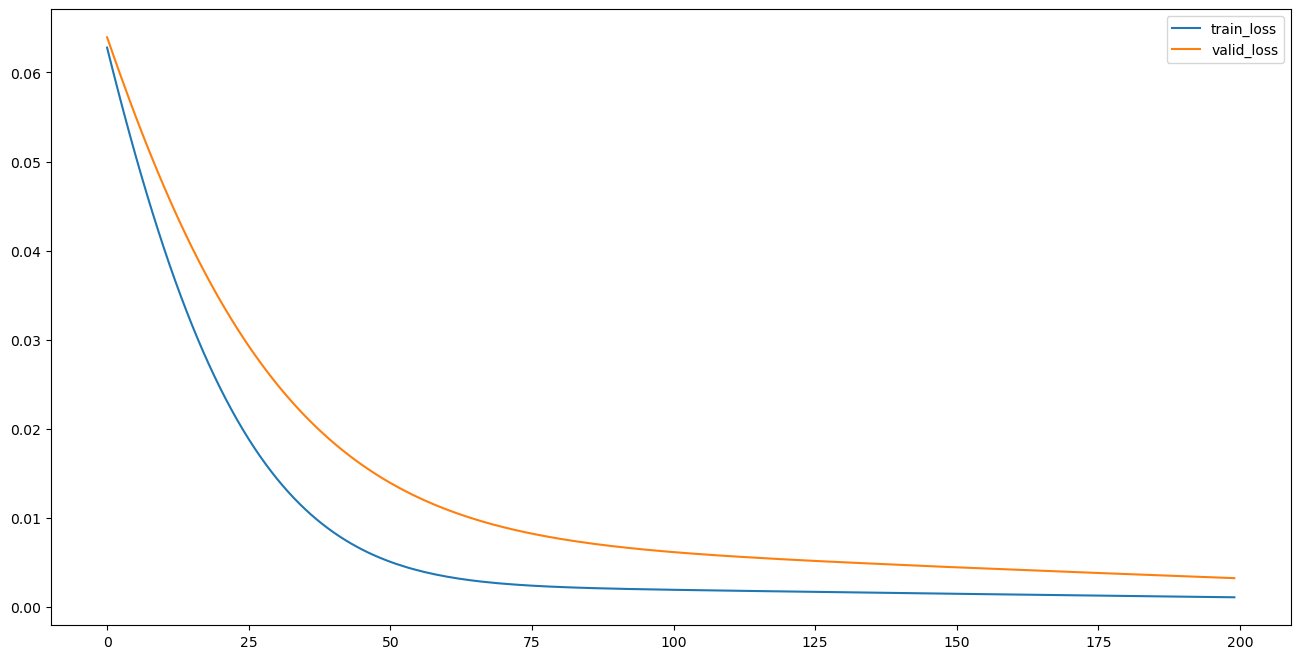

In [63]:
# 新建一个图像
plt.figure(figsize=(8, 4))

# 绘制 train_loss 曲线
plt.plot(train_losses, label='train_loss')

# 绘制 valid_loss 曲线
plt.plot(valid_losses, label='valid_loss')

# 展示带标签的图像
plt.legend()
plt.show()

下面绘制 `MAE` 与 `RMSE` 在 `epoch` 中的变化。

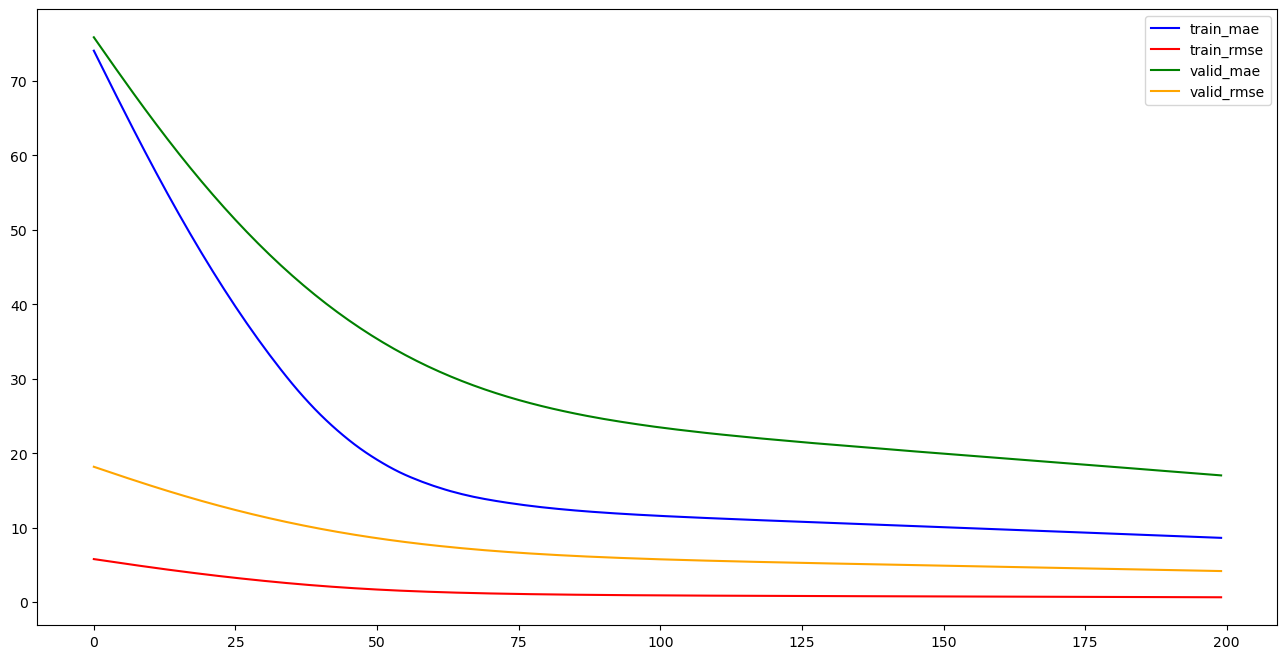

In [64]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 绘画结点
plt.plot(train_maes, c='blue', label='train_mae')

plt.plot(train_mapes, c='red', label='train_rmse')

plt.plot(valid_maes, c='green', label='valid_mae')

plt.plot(valid_mapes, c='orange', label='valid_rmse')

# 展示图像
plt.legend()
plt.show()

下面绘制结点 $5$ 在校验集中与真实值的差距。这里仅考虑 `Notebook(CPU)` ， `GPU` 版本的需要稍加修改。

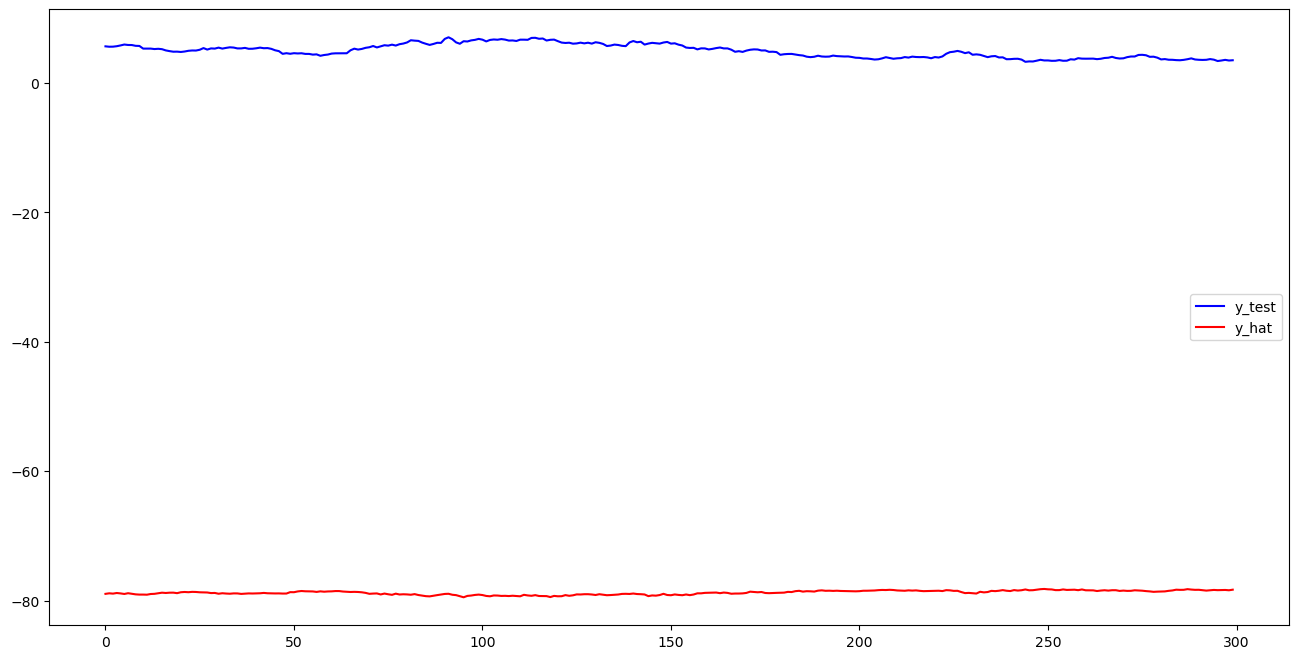

In [65]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 预测结果
y_hat = model(x_test).detach()

# 取前 300 个测试集
num_for_draw = 300

# 绘画某些结点第一天的情况
plt.plot(scaler.inverse_transform(y_test[:num_for_draw].reshape(-1,1)).reshape(-1), c='blue', label='y_test')

plt.plot(scaler.inverse_transform(y_hat[:num_for_draw].reshape(-1,1)).reshape(-1), c='red', label='y_hat')

# 展示图像
plt.legend()
plt.show()

当在校验集上取得较为满意的结果的时候，可以来到测试集一试。

In [66]:
# 获得测试集的数据
test_mae, test_mape = evaluate_accuracy(test_iter, model)

print('test mae, rmse: %.3f,%.3f' % (test_mae,test_mape))

test mae, rmse: 83.130,19.820


在测试集也能取得满意结果的时候，可以在平台上测试并提交。

### 2.3.6 保存和读取模型

下面介绍保存和读取模型。模型应当保存在`results`文件夹下。

In [67]:
# 设计目录
model_path = 'results/mymodel.pt'
# 保存模型
torch.save(model.state_dict(), model_path)

读取模型

In [69]:
# 指定目录
model_path = 'results/mymodel.pt'
# 选用使用的模型类
model = LinearNet(num_inputs,num_outputs)
# 读入对应的参数
model.load_state_dict(torch.load(model_path))
# 
model.eval()

LinearNet(
  (linear): Linear(in_features=14, out_features=1, bias=True)
)

 ### 2.3.7  torch 张量 和 numpy.ndarray 数据类型相互转换  

In [70]:
# torch.Tensor 转化为 numpy.ndarray
x_torch = torch.empty(3,5)
print(type(x_torch))

# torch to numpy
x_numpy = x_torch.numpy()
x_numpy_v2 = np.array(x_torch)
print(type(x_numpy))
print(type(x_numpy_v2))

# numpy to torch
x_torch_v2 = torch.from_numpy(x_numpy)
print(type(x_torch_v2))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>


# 3.作业

## 3.1 训练模型
- 模型训练时请主要在 `GPU` 上训练，在平台上可以使用离线任务 `GPU` 完成，并将模型保存到 `results` 文件夹中，并在模型预测时读取。

In [71]:
def train():
    '''训练模型
    :return: model 一个训练好的模型
    '''
    
    model = None
    # --------------------------- 此处下方加入训练模型相关代码 -------------------------------
    
    
    
    
    
    # 如果使用的不是 pytorch 框架，还需要改动下面的代码
    # 模型保存的位置
    model_path = 'results/mymodel.pt'
    # 保存模型
    torch.save(model.state_dict(), model_path)
    # --------------------------- 此处上方加入训练模型相关代码 -------------------------------
    
    
    
    return model


## 3.2 模型预测

注意事项：
1. 本实验并不严格限定使用的框架，可以使用 `Pytorch` , `Tensorflow` 或其他框架。只需训练好模型并保存，并在下文中写入合适的读取模型并实现预测即可。
2. 点击左侧栏`提交作业`后点击`生成文件`则只需勾选 `predict()` 函数的cell，即【**模型预测代码答题区域**】的 cell。
3. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
4. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
5. `predict()`函数的输入和输出请**不要改动**。
6. 注意，模型预测 `x.shape[0] < 20000` 的数据不能超过 $5$ 分钟，否则将被记为超时。
7. `predict()`函数 返回的类型必须是 `numpy` 数组类型。
8. 实验指标为平均绝对误差（ `MAPE` ）和平均绝对误差（ `MAE` ）。
9. 作业测试时记得填写你的模型路径及名称, 如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请将模型保存在 **results** 文件夹下。

在下方规定区域内写入**加载模型**的方式，该函数是在被测试和评估时调用的**预测函数**。注意，为了便于用户使用各种框架，输出的数组必须为 `numpy` 数组。

 ==================  **提交 Notebook 训练模型结果数据处理参考示范**  ==================

In [72]:
# 1.导入相关第三方库或者包（根据自己需求，可以增加、删除等改动）
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import torch
from sklearn.preprocessing import MinMaxScaler

# 2.导入 Notebook 使用的模型
# 建立一个简单的线性模型
class LinearNet(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        # 一个线性层
        self.linear = torch.nn.Linear(num_inputs, num_outputs)
        
    # 前向传播函数
    def forward(self, x): # x shape: (batch, 14)
        y = self.linear(x)
        return y


============================  **模型预测代码答题区域**  ============================
<br>
在下方的代码块中编写 **模型预测** 部分的代码，请勿在别的位置作答

In [73]:
# 加载 Notebook 模型流程

# 输入的数量是前 14 个交易日的收盘价
num_inputs = 14
# 输出是下一个交易日的收盘价
num_outputs = 1

# ------------------------- 请加载您最满意的模型网络结构 -----------------------------
# 读取模型
model = LinearNet(num_inputs,num_outputs)
    
# ----------------------------- 请加载您最满意的模型 -------------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 temp.pth 模型，则 model_path = 'results/mymodel.pt'
# 模型保存的位置，如果模型路径不同，请修改！！！
model_path = 'results/mymodel.pt'
model.load_state_dict(torch.load(model_path))
model.eval()

def predict(test_x):
    '''
    对于给定的 x 预测未来的 y 。
    :param test_x: 给定的数据集合 x ，对于其中的每一个元素需要预测对应的 y 。e.g.:np.array([[6.69,6.72,6.52,6.66,6.74,6.55,6.35,6.14,6.18,6.17,5.72,5.78,5.69,5.67]]
    :return: test_y 对于每一个 test_x 中的元素，给出一个对应的预测值。e.g.:np.array([[0.0063614]])
    '''
    # test 的数目
    n_test = test_x.shape[0]
    
    test_y = None
    # --------------------------- 此处下方加入读入模型和预测相关代码 -------------------------------
    # 此处为 Notebook 模型示范，你可以根据自己数据处理方式进行改动
    # scaler = MinMaxScaler().fit(np.array([0, 300]).reshape(-1, 1))
    # test_x = scaler.transform(test_x.reshape(-1, 1)).reshape(-1, 14)
    test_x = torch.tensor(test_x, dtype=torch.float32)
    
    test_y = model(test_x)
    
    # 如果使用 MinMaxScaler 进行数据处理，预测后应使用下一句将预测值放缩到原范围内
    # test_y = scaler.inverse_transform(test_y.detach().cpu())
    test_y = test_y.detach().cpu().numpy()
    # --------------------------- 此处上方加入读入模型和预测相关代码 -------------------------------
    
    # 保证输出的是一个 numpy 数组
    assert(type(test_y) == np.ndarray)
    
    # 保证 test_y 的 shape 正确
    assert(test_y.shape == (n_test, 1))
    
    return test_y

In [74]:
# 测试用例
model_test_x = np.array([[6.69,6.72,6.52,6.66,6.74,6.55,6.35,6.14,6.18,6.17,5.72,5.78,5.69,5.67]])
print(predict(test_x = model_test_x))

[[-1.873996]]


## 3.3 提交程序报告

为了检查作业的详实程度及具体方法，本实验需要提交程序报告。

提交作业时请记得左侧文件列表中上传『程序报告.docx』或者 『程序报告.pdf』。